In [1]:
import pandas as pd
import pm4py

### Importing the log

In [2]:
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.conversion.log import converter
file_path = "./Road_Traffic_Fine_Management_Process.xes"
xes_event_log = xes_importer.apply(file_path)

event_log = converter.apply(xes_event_log, variant=converter.Variants.TO_DATA_FRAME)

event_log

parsing log, completed traces ::   0%|          | 0/150370 [00:00<?, ?it/s]

,amount,org:resource,dismissal,concept:name,vehicleClass,totalPaymentAmount,lifecycle:transition,time:timestamp,article,points,case:concept:name,expense,notificationType,lastSent,paymentAmount,matricola
0,35.0,561,NIL,Create Fine,A,0.0,complete,2006-07-24 00:00:00+02:00,157.0,0.0,A1,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2006-12-05 00:00:00+01:00,NaN,NaN,A1,11.00,NaN,NaN,NaN,NaN
2,35.0,561,NIL,Create Fine,A,0.0,complete,2006-08-02 00:00:00+02:00,157.0,0.0,A100,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2006-12-12 00:00:00+01:00,NaN,NaN,A100,11.00,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,Insert Fine Notification,NaN,NaN,complete,2007-01-15 00:00:00+01:00,NaN,NaN,A100,NaN,P,P,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561465,131.0,25,NIL,Create Fine,A,0.0,complete,2002-09-07 00:00:00+02:00,142.0,0.0,V9999,NaN,NaN,NaN,NaN,NaN
561466,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2002-10-25 00:00:00+02:00,NaN,NaN,V9999,15.16,NaN,NaN,NaN,NaN
561467,NaN,NaN,NaN,Insert Fine Notification,NaN,NaN,complete,2002-11-04 00:00:00+01:00,NaN,NaN,V9999,NaN,P,N,NaN,NaN
561468,262.0,NaN,NaN,Add penalty,NaN,NaN,complete,2003-01-03 00:00:00+01:00,NaN,NaN,V9999,NaN,NaN,NaN,NaN,NaN


In [ ]:
start_activities = pm4py.get_start_activities(event_log)
end_activities = pm4py.get_end_activities(event_log)
print("Start activities: {}\nEnd activities: {}".format(start_activities, end_activities))

### Process Discovery
Petri Net (using two different algorithms)

c:\users\diego\desktop\pm4py-test\venv\lib\site-packages\pm4py\algo\discovery\dfg\adapters\pandas\df_statistics.py:82: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_reduced = df[{case_id_glue, activity_key, target_activity_key}]


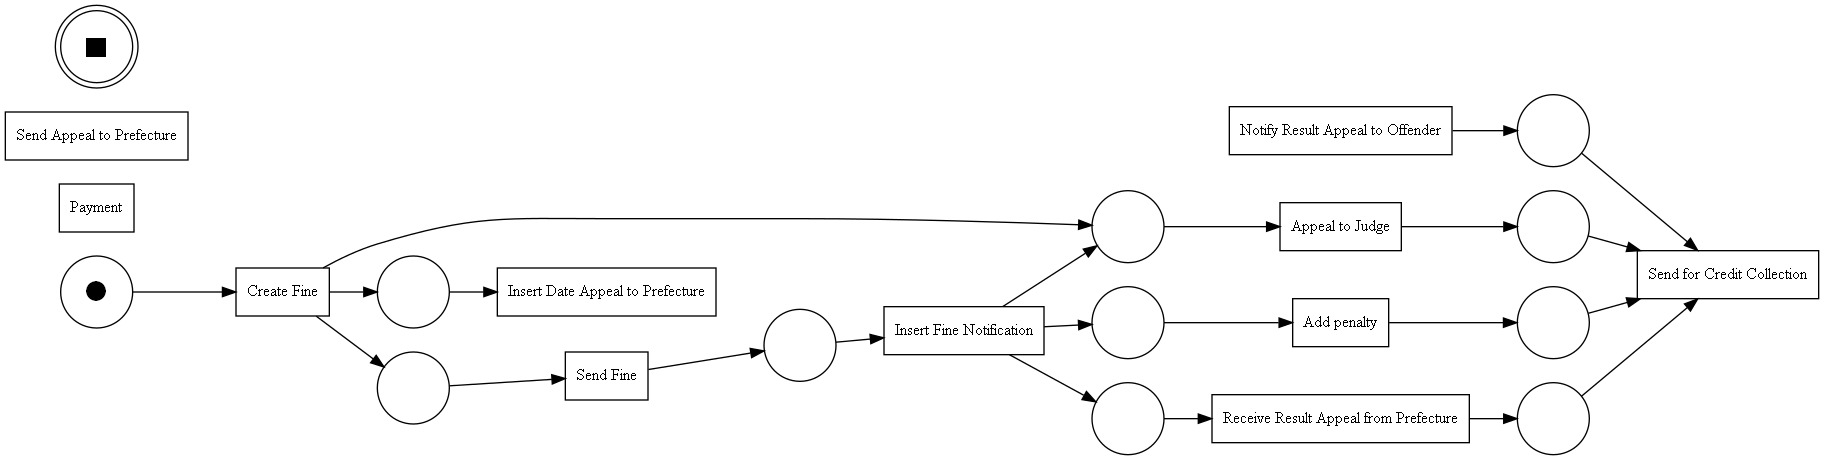

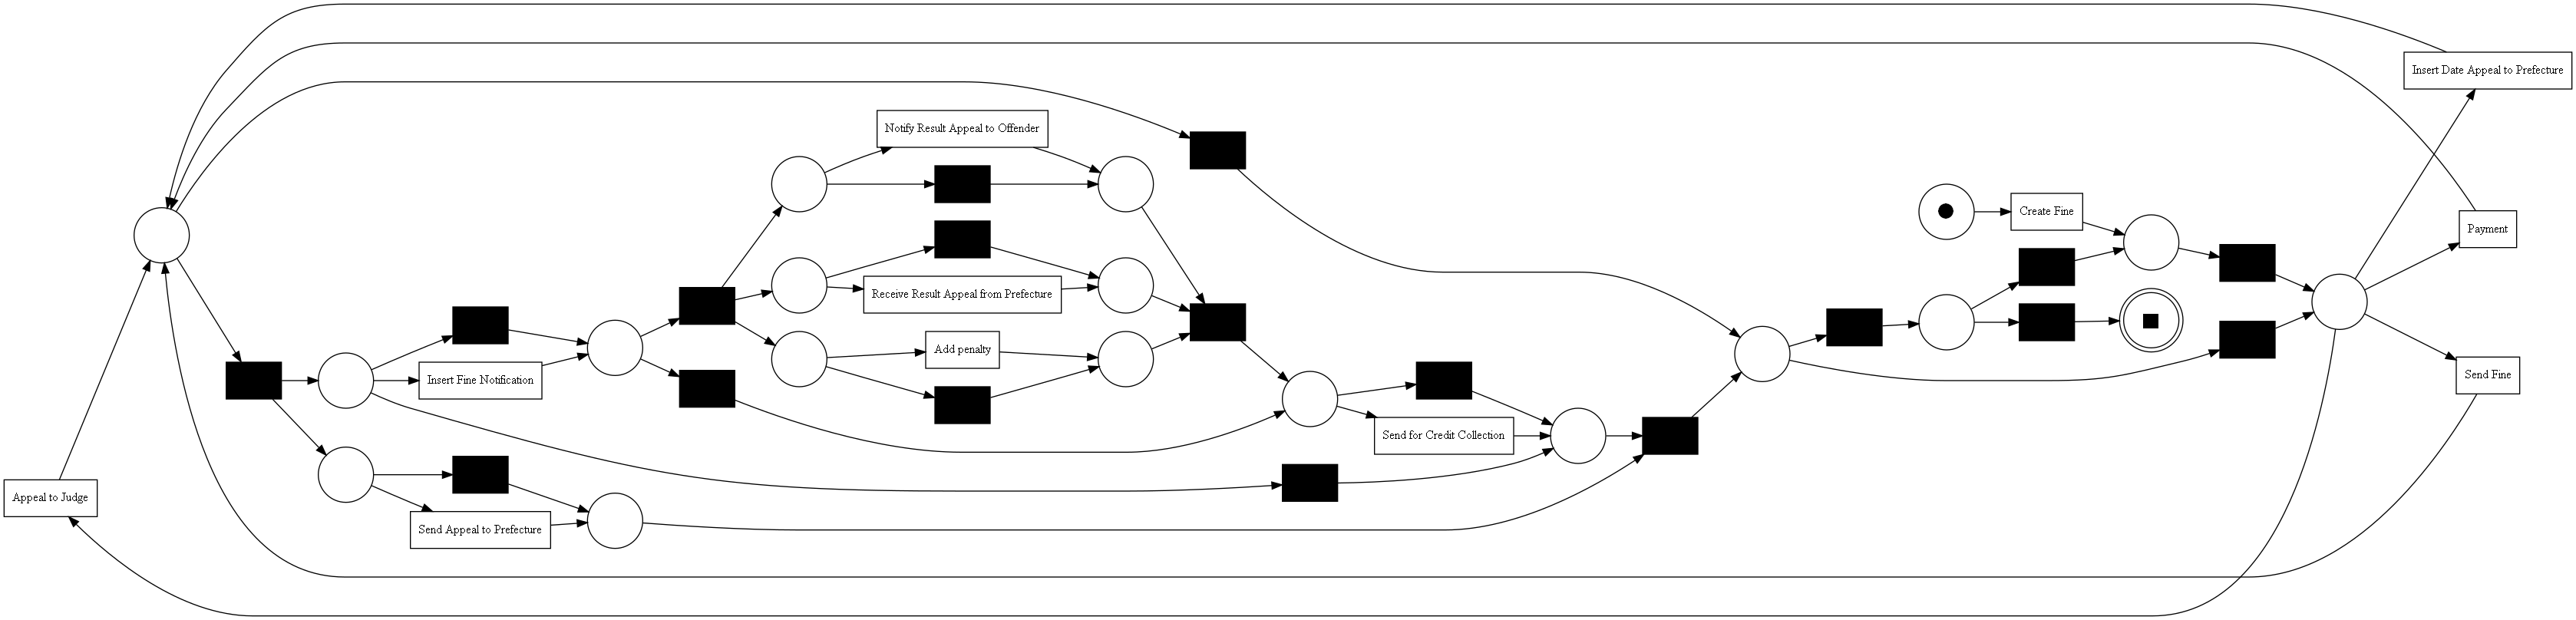

In [3]:
from pm4py.visualization.petri_net import visualizer as pn_visualizer

# Alpha Miner
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
alpha_net, alpha_initial_marking, alpha_final_marking = alpha_miner.apply(event_log)
alpha_graphviz = pn_visualizer.apply(alpha_net, alpha_initial_marking, alpha_final_marking)
alpha_graphviz.graph_attr['bgcolor'] = 'white'
pn_visualizer.view(alpha_graphviz)
# pn_visualizer.save(alpha_graphviz, "pn_alpha_miner.png")

# Inductive Miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
ind_net, ind_initial_marking, ind_final_marking = inductive_miner.apply(event_log)
ind_graphviz = pn_visualizer.apply(ind_net, ind_initial_marking, ind_final_marking)
ind_graphviz.graph_attr['bgcolor'] = 'white'
pn_visualizer.view(ind_graphviz)
# pn_visualizer.save(ind_graphviz, "pn_inductive_miner.png")

Other possible process models

In [ ]:
# Process Tree
process_tree = pm4py.discover_process_tree_inductive(event_log)
pm4py.view_process_tree(process_tree)

# BPMN Model
bpmn_model = pm4py.convert_to_bpmn(process_tree)
pm4py.view_bpmn(bpmn_model)

# Process Map (Directly Follows Graph)
dfg, start_activities, end_activities = pm4py.discover_dfg(event_log)
pm4py.view_dfg(dfg, start_activities, end_activities)

# Heuristic Miner
heu = pm4py.discover_heuristics_net(event_log)
pm4py.view_heuristics_net(heu)

### Decision points

In [4]:
# For each decision point (place with at least 2 outgoing arcs), gets the labels of the target transitions
# Invisible transitions (in case of the inductive miner) are not taken into account for now: decision nodes with invisible transitions are simply not considered in the analysis

decision_points_and_trans = dict()

def find_decision_point_transitions(dec_point):
    for arc in dec_point.out_arcs:
        if arc.target.label is not None:
            decision_points_and_trans[dec_point].append(arc.target.label)
        #else:
            #trans_out = arc.target
            #trans_out_arcs = trans_out.out_arcs
            #for arc2 in trans_out_arcs:
                #find_decision_point_transitions(arc2.target)

    # Removing nodes with following invisible transitions (= only one transition in the dictionary)
    if len(decision_points_and_trans[dec_point]) < 2:
        del decision_points_and_trans[dec_point]

for place in ind_net.places:
    if len(place.out_arcs) >= 2:
        decision_points_and_trans[place] = list()
        find_decision_point_transitions(place)

decision_points_and_trans

{p_7: ['Appeal to Judge',
  'Payment',
  'Send Fine',
  'Insert Date Appeal to Prefecture']}

### Observation instances
Now that for every decision point we have the list of observed transitions, we need to build the observation instances.
The observation instances of a decision point are the instances (x, t) where x are the observed values of the attributes, while t is the observed transition.
So, every time we see a transition t in the event log, we retrieve the values x of the attributes before the transition happens, and we add the instance to the observation instances for that decision point.

In [5]:
import math

features = ['amount', 'totalPaymentAmount', 'article', 'points']# 'expense', 'paymentAmount', 'matricola']
features_values = list()

gb = event_log.groupby(['case:concept:name'])

def create_dataframe_for_dp(dp):
    # For each case (=sequence) it starts looking at the dataframe rows.
    # Whenever it finds an event corresponding to a transition we are interested in (=one linked to the decision point currently analyzed), it starts scanning for features values.
    # For each feature, it looks for its value starting from the current row, and possibly going back towards the beginning of the case, to retrieve a value for each feature.
    # In case it does not find a value for some specific feature, we consider it as "None".
    # All these values are put in an "instance_list", along with the name of the transition which started this retrieval.
    # Then, this list is appended to the "features_values" one, which is a list containing one list for each event of interest (each one with features values + transition name)
    for case in gb.groups:
        for row in gb.groups[case]:
            if event_log.iloc[row]['concept:name'] in decision_points_and_trans[dp]:
                row_iter = row - 1          # STARTING FROM THE LINE BEFORE THE TRANSITION HAPPENED
                instance_list = list()
                for feature in features:
                    found = False
                    while row_iter >= gb.groups[case][0]:
                        if not math.isnan(event_log.iloc[row_iter][feature]):
                            instance_list.append(event_log.iloc[row_iter][feature])
                            found = True
                            break
                        row_iter = row_iter - 1
                    if not found:
                        instance_list.append(math.nan)
                instance_list.append(event_log.iloc[row]['concept:name'])
                features_values.append(instance_list)

    # Creating the dataframe for the specific decision point analyzed, with features values and transition for each event analyzed
    # The decision point ID is also written, because then all these dataframes will be merged into a single one
    df_trans = pd.DataFrame(features_values, columns=features+['transition'])
    df_trans['decision point'] = dp

    return df_trans

# For each decision point found, it creates a dataframe containing the attribute values for each event of interest, according to the observed transitions
dp_dataframes = list()
for decision_point in decision_points_and_trans.keys():
    df_dp = create_dataframe_for_dp(decision_point)
    dp_dataframes.append(df_dp)

# In the end, we have a single dataframe for all the decision points, containing [attribute values, decision point, observed transition] for every event of interest
final_df = pd.concat(dp_dataframes)

final_df

,amount,totalPaymentAmount,article,points,transition,decision point
0,35.0,0.0,157.0,0.0,Send Fine,p_7
1,35.0,0.0,157.0,0.0,Send Fine,p_7
2,36.0,0.0,157.0,0.0,Send Fine,p_7
3,74.0,0.0,157.0,0.0,Payment,p_7
4,36.0,0.0,157.0,0.0,Send Fine,p_7
...,...,...,...,...,...,...
186326,131.0,0.0,142.0,0.0,Send Fine,p_7
186327,131.0,0.0,142.0,0.0,Payment,p_7
186328,131.0,0.0,142.0,0.0,Send Fine,p_7
186329,131.0,0.0,142.0,0.0,Send Fine,p_7


### Decision Tree
One tree for each decision point. For now, since I have only one decision point, I directly use the whole dataframe obtained.

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

classes = final_df['transition'].unique()

X_train, X_test, Y_train, Y_test = train_test_split(final_df[features], final_df['transition'], random_state=0)

In [27]:
tree_clf = DecisionTreeClassifier(max_depth = 5, random_state = 0)

tree_clf.fit(X_train, Y_train)

DecisionTreeClassifier(max_depth=5, random_state=0)

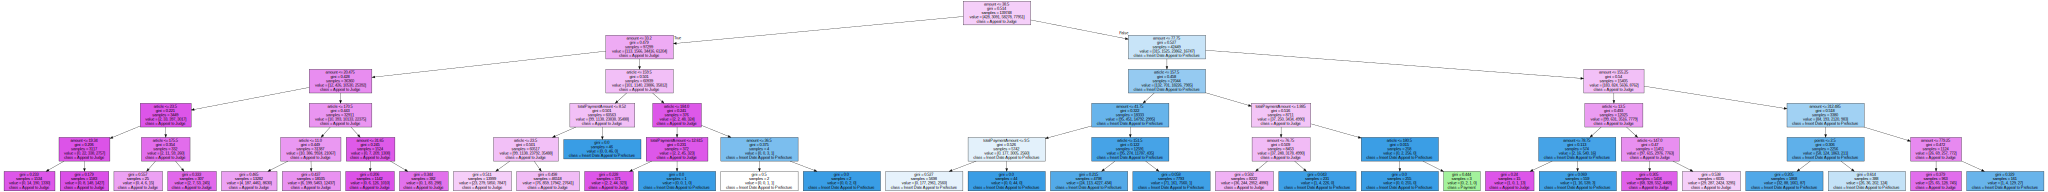

In [28]:
from sklearn import tree

import graphviz
dot_data = tree.export_graphviz(tree_clf, out_file=None,
                                feature_names=features,
                                class_names=classes,
                                filled=True)

graph = graphviz.Source(dot_data, format="png")
graph.render("decision_tree_graphivz")